In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from tqdm import tqdm
import numba
import time

# MD - Code

In [2]:
def init_pos(N, Grid, L):
    
    xmin = ymin = zmin = Grid
    xmax = ymax = zmax = L
    
    X, Y, Z = np.mgrid[xmin:xmax:Grid, ymin:ymax:Grid, zmin:zmax:Grid]
    positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    init = np.random.choice(len(positions.T), replace = False, size = N)
    
    return positions.T[init]

def init_vel(N, SD, DIS):
    
    if DIS == 'normal':
        assert SD > 0, 'STD should be > 0'
        
        return np.random.normal(size = (N, 3), loc = 0, scale = SD)
    
    if DIS == 'uniform':
        
        return np.random.uniform(size = (N, 3))
    
def init(N, Grid, L, SD, DIS):
    
    return init_pos(N, Grid, L), init_vel(N, SD, DIS)

In [3]:
def write_file(FILE1, FILE2, FILE3, FILE4, coords, vels, PE, KE, n_iter, names):


    #Coordinates are round to the second decimal position to faciliate saving
    round_ = 2

    #Write head for each frame12     
    FILE1.write('Model {}\n'.format(n_iter)) #Start of a frame
    FILE2.write('Model {}\n'.format(n_iter)) #Start of a frame
    N = coords.shape[0]

    #Just iterate over all coordinates and write them down line per line
    for i in range(N):

        #The PDB-formate is really strict the line below is from: https://cupnet.net/pdb-format/

        #ATOM  #ID   #NAME     #RESN      #RESID          #X    #Y     #Z
        coord_str = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}\n".format('ATOM', int(i),
                                                                                                                         'PAR', ' ', names[i],
                                                                                                                         ' ', int(i), ' ',
                                                                                                                         np.round(coords[i][0], round_)*10,
                                                                                                                         np.round(coords[i][1], round_)*10,
                                                                                                                         np.round(coords[i][2], round_)*10,
                                                                                                                          1.0, 1.0, names[i], ' ')


        FILE1.write(coord_str) #Write coordinates
        FILE2.write('{}\t\t{}\t\t{}\n'.format(vels[i][0], vels[i][1], vels[i][2])) #Write velocities
    FILE1.write('TER\nENDMDL\n') #End of a frame

    #Write down Temperature, Pressure and Volume
    FILE3.write('{};{}\n'.format(n_iter, PE))
    FILE4.write('{};{}\n'.format(n_iter, KE))
                                                

In [14]:
@numba.jit(nopython = True, fastmath = True)
def ideal_volume(T, N, P):
    
    return ((T * N * 1.38) / (P * 1E+1))**(1./3.)

In [4]:
@numba.jit(nopython = True, fastmath = True)
def pbc_dist(r_ij, L):
    
    dist_vec = np.zeros(3)
    
    for i in range(3):
        
        abs_liste = np.array([r_ij[i], r_ij[i] + L, r_ij[i] - L])
        argmin_abs = np.argmin(np.abs(abs_liste))
        
        dist_vec[i] = abs_liste[argmin_abs]
        
    dist = np.linalg.norm(dist_vec)
        
    return dist, dist_vec

In [5]:
@numba.jit(nopython = True, fastmath = True)
def pair_list(r, N, rc, L):
    
    pair_list_x = []
    pair_list_y = []
    
    for i in range(0, N):
        for j in range(i+1, N):
            
            diff_ij = r[i] - r[j]
            
            dr_ij, r_ij = pbc_dist(diff_ij, L)
            
            if dr_ij <= rc: 
                pair_list_x.append(i)
                pair_list_y.append(j)
                
            else: pass
    
    return np.array([pair_list_x, pair_list_y], dtype = np.int32)

In [31]:
@numba.jit(nopython = True, fastmath = True)
def kinetic(v, m):
    
    return 0.5 * np.sum(m * v**2)

In [16]:
@numba.jit(nopython = True, fastmath = True)
def pbc(r, v, L):
    
    r %= L
    
    mean = np.zeros(3)
    counter = 0
    for vec in v:
        mean += vec
        counter +=1
    mean /= counter
    v -= mean #np.mean(a = v, axis = 0)
    
    return r, v

In [28]:
@numba.jit(nopython = True, fastmath = True)
def pressure(N, V, T, dV):
    
    NA = 6.02214086
    
    S1 = N * constants.R * 1E-3 * T
    
    S2 = 1.0/3.0 * dV

    return (S1 + S2) * (1/V) * 1E+2 / NA

@numba.jit(nopython = True, fastmath = True)
def force(rdt, N, sig, eps, pair_mask, L, rc, T, idx_arr):
    
    f = np.zeros((N, 3))
    
    Vol = L * L * L
    
    dV_sum = 0
    
    pote = 0
    
    for pair in pair_mask.T:
        
        i, j = pair
        k, l = idx_arr[i], idx_arr[j]
            
        diff_ij = rdt[i] - rdt[j]
            
        dr_ij, r_ij = pbc_dist(diff_ij, L)
        
        if dr_ij <= rc:
            
            dV = 48. * eps[k, l] * ((sig[k, l]**12)*(dr_ij**-13) - 0.5 *  (sig[k, l]**6)*(dr_ij**-7))
        
            f_ij = dV / dr_ij * r_ij

            f[i] += f_ij
            f[j] -= f_ij
        
            pote += 4. * eps[k, l] * ((sig[k, l]/dr_ij)**12 - (sig[k, l]/dr_ij)**6)
            
            dV_sum += dV * dr_ij
            
    p = pressure(N, Vol, T, dV_sum)
    
    return f, pote, p

@numba.jit(nopython = True, fastmath = True)
def velocity_verlet(r, v, f, m, eps, sig, dt, boundary, N, L, pair_list_update, rc, rb, step, pair_mask, T, IndexArray):
    
    rdt = r + dt * v + f * dt**2 / 2 / m

    rdt, v = boundary(rdt, v, L)
    
    if not step % pair_list_update: pair_mask = pair_list(rdt, N, rb, L)
    
    fdt, pote, press = force(rdt, N, sig, eps, pair_mask, L, rc, T, IndexArray) 
    
    vdt = v + dt * (f + fdt) / 2 / m
    
    return rdt, vdt, fdt, pote, pair_mask, press
    
    

In [42]:
@numba.jit(nopython = True, fastmath = True)
def temperature(v, m, N):
    
    return (1E+3 * np.sum(m * v**2)) / (3 * N * constants.R)

@numba.jit(nopython = True, fastmath = True)
def berendsen_thermostat(T0, T, dt, tau, v):
    
    v *= np.sqrt(1 + (dt/tau) * (T0/T - 1))
    
    return v

@numba.jit(nopython = True, fastmath = True)
def berendsen_barostat(P0, P, dt, beta, tau, L, r):
    
    mu = (1 + dt * beta * (P - P0) / tau)**(1./3.)
    
    L *= mu
    r *= mu
    
    return L, r

In [43]:
def interaction_matrix(sig, eps):
    
    sig_matrix = np.zeros((len(sig), len(sig)))
    eps_matrix = np.zeros((len(eps), len(eps)))
    
    for i in range(len(sig)):
        for j in range(len(sig)):
            
            sig_matrix[i, j] = (sig[i] + sig[j]) / 2
            eps_matrix[i, j] = np.sqrt((eps[i] * eps[j]))
            
    return sig_matrix, eps_matrix

In [45]:
def main(n_steps, N, L, dt, v_static, p_static, TEMPS, TEMP0, PRESS0, init_random, boundary, update, pair_list_update, rc, rb, tauT, tauP, file1, file2, file3, file4, r_init = 0, v_init = 0, distri = 'normal', modL = 1., write_pdb = True):
    
    #Argon
    #m = 39.948 #a.m.u.
    #sig = 0.34
    #eps = 1.0
    
    #Neon
    #m = 20.180 #a.m.u.
    #sig = 0.28
    #eps = 0.3
    
    ##########################
    #Define atomic parameters#
    ##########################
    
    nam = np.array(['ARG', 'NEO'])
    m = np.array([39.948, 20.180])
    Sigma = np.array([0.34, 0.28])
    Epsilon = np.array([1.0, 0.3])
    
    ##############################
    #Calculate interaction matrix#
    ##############################
    
    sig, eps = interaction_matrix(Sigma, Epsilon)
    
    #######################################
    #Make index array for accessing values#
    #######################################
    
    if type(N) == int: pass
    
    elif type(N) == list:
        
        TotalN = sum(N)
        
        IndexArray = np.zeros(TotalN, dtype = np.int32)
        
        N_CumSum = np.cumsum(N)
        
        for idx in N_CumSum: IndexArray[idx:]+=1
            
    m = m[IndexArray].reshape((-1, 1))
    nam = nam[IndexArray]
        
    beta = 1.8*10**(-4)
    
    f1, f2, f3, f4 = open(file1, 'w'), open(file2, 'w'), open(file3, 'w'), open(file4, 'w')
    
    s = str('CRYST1'+ str("{:9.3f}{:9.3f}{:9.3f}".format(L*10,L*10,L*10)) + "  90.00  90.00  90.00 P 1           1\n")
   # f1.write(s)
    
    if init_random: 
        
        mass_mean = np.mean(m)
        
        sd = np.sqrt(constants.R * 0.001 * TEMPS / mass_mean)
        r, v = init(TotalN, 0.5, L, sd, distri)
        
        if boundary == pbc: v -= np.mean(v, axis = 0)
        
    else:
        
        r = r_init
        v = v_init
        
    kin_ener = np.zeros(int(n_steps / update))
    pot_ener = np.zeros(int(n_steps / update))
    temp = np.zeros(int(n_steps / update))
    pressure = np.zeros(int(n_steps / update))
    vel_store = np.zeros((int(n_steps / update), TotalN, 3))
    volume = np.zeros(int(n_steps / update))
    
    T = temperature(v, m, TotalN)
    pair_mask = pair_list(r, TotalN, rb, L)
    f, pote, press = force(r, TotalN, sig, eps, pair_mask, L, rc, T, IndexArray)
    
    kine = kinetic(v, m)
    
    kin_ener[0] = kine
    pot_ener[0] = pote
    vel_store[0] = v
    temp[0] = T
    pressure[0] = press
    volume[0] = L**3
    
    write_file(f1, f2, f3, f4, r, v, pote, kine, 0, nam)
        
    c = 1
    
    for step in tqdm(range(1, n_steps)):
        
        r, v, f, pote, pair_mask, press = velocity_verlet(r, v, f, m, eps, sig, dt, boundary, TotalN, L,
                                                          pair_list_update, rc, rb, step, pair_mask, T,
                                                          IndexArray)
        
        if v_static:
            v = berendsen_thermostat(T0 = TEMP0, T = T, dt = dt, tau = tauT, v = v)
            
        if p_static:
            L, r = berendsen_barostat(P0 = PRESS0, P = press, dt = dt, beta = beta, tau = tauP, L = L, r = r)
        else:
            L*=modL
            r*=modL
        
        T = temperature(v, m, TotalN)
        
        
        if not step % update: 
            
            if write_pdb: write_file(f1, f2, f3, f4, r, v, pote, kine, step, nam)
            
            kine = kinetic(v, m)
            
            kin_ener[c] = kine
            pot_ener[c] = pote
            vel_store[c] = v
            temp[c] = T
            pressure[c] = press
            volume[c] = L**3
            
            c+=1
            
    return kin_ener, pot_ener, vel_store, temp, pressure, volume

In [95]:
OUT = main(n_steps = 500000,
           N = [1, 1],
           L = 10, #ideal_volume(50, 200, 1),
           r_init = np.array([[5., 5., 5.], [5., 5., 6.]]),
           v_init = np.array([[0., 0., 0.], [0., 0., 0.]]),
           dt = 1E-3,
           TEMPS = 50,
           TEMP0 = 50,
           PRESS0 = 1.,
           init_random = False,
           boundary = pbc,
           update = 10,
           pair_list_update = 1,
           rc = 1000.,
           rb = 1500.,
           file1 = 'ARG_NEO.pdb',
           file2 = 'Vel_ARG_NEO.txt',
           file3 = 'POTE_ARG_NEO.txt',
           file4 = 'KINE_ARG_NEO.txt',
           v_static = False,
           p_static = False,
           tauT = 1.0,
           tauP = .1,
           modL = 1,
           write_pdb = True)

100%|██████████| 499999/499999 [01:06<00:00, 7526.87it/s]


In [96]:
PDBraw = np.loadtxt('ARG_NEO.pdb', comments = ['Model', 'TER', 'ENDMDL'], dtype = str)

In [97]:
PDB = PDBraw.reshape((50000, 2, 11))

In [98]:
coords = np.array(PDB[:, :, 5:8], dtype = float) / 10

In [99]:
dist = np.sqrt(np.sum((coords[:, 0, :] - coords[:, 1, :])**2, axis = 1))

In [106]:
sig_argon_neon = (0.34 + 0.28)/2
eps_argon_neon = (1.0 * 0.3)**(1/2)

In [105]:
def len_jon(sig, eps, dist):
    
    return 4. * eps * ((sig/dist)**12 - (sig/dist)**6)

In [112]:
d = np.linspace(0.32, 1.0, 1000)

(-1.1, 0.5)

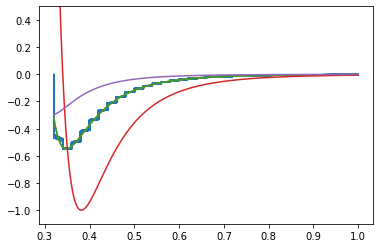

In [116]:
plt.plot(dist, OUT[1])
plt.plot(d, len_jon(sig_argon_neon, eps_argon_neon, d))
plt.plot(d, len_jon(sig_argon_neon, eps_argon_neon, d))
plt.plot(d, len_jon(0.34, 1.0, d))
plt.plot(d, len_jon(0.28, 0.3, d))
plt.ylim(-1.1, 0.5)

(array([ 10.,  10.,  39., 123., 176., 139.,  72.,  23.,   7.,   1.]),
 array([-0.41346107, -0.32541233, -0.23736359, -0.14931485, -0.0612661 ,
         0.02678264,  0.11483138,  0.20288012,  0.29092886,  0.3789776 ,
         0.46702634]),
 <BarContainer object of 10 artists>)

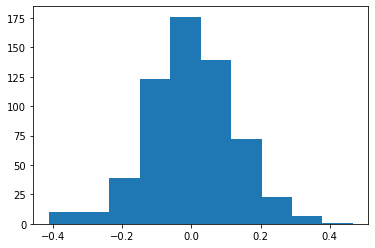

In [60]:
plt.hist(OUT[2][-1, :, :].flatten())

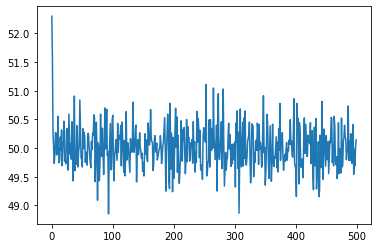

In [53]:
plt.plot(OUT[3])

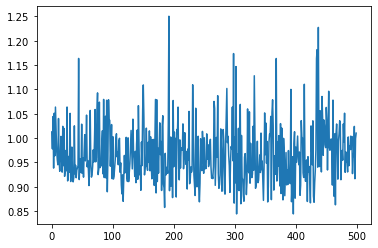

In [54]:
plt.plot(OUT[4])

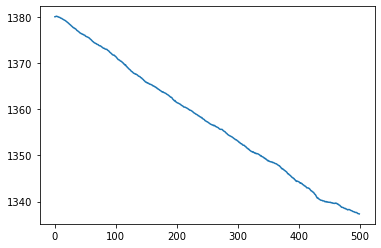

In [56]:
plt.plot(OUT[5])